In [162]:
# Importando bibliotecas 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler


In [163]:
# Lendo o dataset
dataset_Ad = pd.read_csv('/content/sample_data/Advertising.csv')
dataset_Ad.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [164]:
# Verificar o tipo de dado das colunas do Dataset
dataset_Ad.dtypes
# todos as features numéricas

TV           float64
radio        float64
newspaper    float64
sales        float64
dtype: object

In [165]:
# observando por alto a distribuição dos dados
dataset_Ad.describe().transpose()
# aparentemente a distribuição dos valores está ok

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


In [166]:
# Percentual de dados faltantes na base de treino
dataset_Ad.isnull().mean() *100

TV           0.0
radio        0.0
newspaper    0.0
sales        0.0
dtype: float64

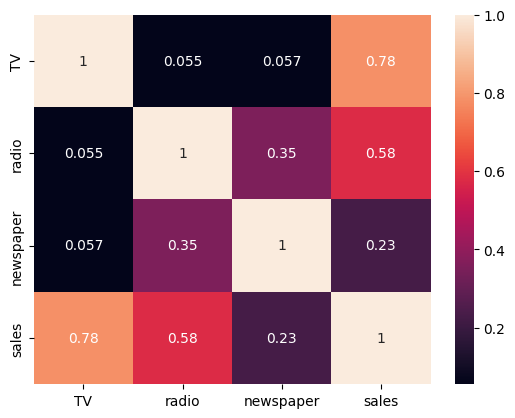

In [167]:
# gerando a matriz de correlação das features
corr = dataset_Ad.corr(method = 'pearson')
sn.heatmap(corr, annot=True)
plt.show()

In [168]:
# podemos ver que a feature com maior correlação com 'sales',
# que é nosso atributo de saída, é a feature 'TV'.
# portanto, será esta feature que usaremos no modelo de regressão.
features = ["TV"]
X = dataset_Ad[features]
y = dataset_Ad.sales

In [169]:
X.head()

,TV
0,230.1
1,44.5
2,17.2
3,151.5
4,180.8


In [170]:
y.head()

0    22.1
1    10.4
2     9.3
3    18.5
4    12.9
Name: sales, dtype: float64

In [171]:
# função que gera os conjuntos de treino e teste de forma pseudo-aleatória
def generateTrainTest(X, y):
  rnd = np.random.randint(1000)
  return train_test_split(X, y, test_size=0.30, random_state=rnd)

# função que retorna a Residual sum of squares
def RSS(y, y_pred):
  sum = 0
  for y, yp in zip(y, y_pred):
    sum += (y - yp)**2
  return sum

# função que retorna a Residual sum of squares
def RSE(y, y_pred, model_n_params = 2):
  return np.sqrt(RSS(y, y_pred)/(len(y)-model_n_params))

# função que retorna o Standard error para theta0
def SETheta0(X, rse):
  sum = 0
  for x in X:
    sum += (x - X.mean())**2
  return rse * np.sqrt(1/len(X) + (X.mean()**2)/sum)

# função que retorna o Standard error para theta1
def SETheta1(X, rse):
  sum = 0
  for x in X:
    sum += (x - X.mean())**2
  return rse * np.sqrt(1/sum)

# função que retorna R-squared ajustado,
# onde n = número de instâncias no conjunto e
# k = número de variáveis de entrada
def R_sq_Adjusted(n, k, RSquared):
  return 1-((1-RSquared)*(n-1)/(n-k-1))



In [172]:
# colunas do df para guardar os resultados
columns = ['Coeficiente','Intercept','Equação','RSS (Residual Sum of Squares)',
         'RSE (Residual Standard Error)','SE (Standard Error) para Theta 0',
         'SE (Standard Error) para Theta 1','R-squared', 'R-sq-Adjusted', 't-statistics', 'P-value']
lInfo = []

In [173]:
# número de subconjuntos
N_sub = 30

# inicializando variáveis auxiliares
residuals = []
fitted_val = []

In [174]:
for i in range(1,N_sub+1):
  #print("Run", i)
  X_train, X_test, y_train, y_test = generateTrainTest(X, y)
  # constroi o modelo
  model = LinearRegression()

  # treina o modelo
  model.fit(X_train, y_train)

  # faz predição sobre o conjunto de TREINO, para observar os erros
  y_pred = model.predict(X_train)

  # informações para inserir no df
  coef = model.coef_[0]
  intercept = model.intercept_
  eq = "y = " + str(coef) + " * X + " + str(intercept)
  RSSv = RSS(y_train, y_pred)
  RSEv = RSE(y_train, y_pred)
  SETheta0v = SETheta0(X_train['TV'], RSEv)
  SETheta1v = SETheta1(X_train['TV'], RSEv)
  RSquared = model.score(X_train, y_train)
  RSqAdj = R_sq_Adjusted(len(X_train), 1, RSquared)
  # t-stats para o teste de hipótese, onde
  # a hipótese nula = Não existe relação entre X e y (Theta1 = 0)
  # "Sample mean (theta 1) minus population mean you are comparing your sample to (0),
  # divided by the standard error (SETheta1v).
  t_stats = (coef - 0)/SETheta1v
  P_value = f_regression(X_train, y_train)[1][0]

  # informações adicionais
  residuals = y_train - y_pred
  fitted_val = y_pred

  lInfo.append(pd.Series([coef, intercept, eq, RSSv, RSEv, SETheta0v, SETheta1v, RSquared, RSqAdj, t_stats, P_value], index=columns))

In [175]:
# criando o df
df = pd.DataFrame(lInfo)
df

,Coeficiente,Intercept,Equação,RSS (Residual Sum of Squares),RSE (Residual Standard Error),SE (Standard Error) para Theta 0,SE (Standard Error) para Theta 1,R-squared,R-sq-Adjusted,t-statistics,P-value
0,0.048597,6.740948,y = 0.04859669163705478 * X + 6.740948374971697,1365.669335,3.145815,0.509897,0.003039,0.649490,0.646950,15.991013,3.217816e-33
1,0.049407,7.005208,y = 0.049406698875450066 * X + 7.005208205320692,1463.281507,3.256300,0.535608,0.003185,0.635564,0.632923,15.513448,4.783651e-32
2,0.048317,6.859698,y = 0.04831743608663439 * X + 6.85969832763439,1463.146944,3.256150,0.525447,0.003101,0.637591,0.634964,15.581551,3.250625e-32
3,0.049512,6.805128,y = 0.04951190820118514 * X + 6.805127584986455,1473.806575,3.267990,0.557716,0.003266,0.624836,0.622117,15.160437,3.570833e-31
4,0.047082,6.995474,y = 0.04708173562005913 * X + 6.995473696200709,1443.131174,3.233802,0.549306,0.003195,0.611441,0.608625,14.736294,4.060893e-30
5,0.046419,7.258684,y = 0.046419443474802376 * X + 7.258683682678599,1471.163044,3.265058,0.568627,0.003325,0.585435,0.582431,13.959905,3.624135e-28
6,0.047210,7.087235,y = 0.04721015537378088 * X + 7.087235468332188,1568.804660,3.371669,0.578733,0.003306,0.596422,0.593497,14.280796,5.628295e-29
7,0.045323,7.339226,y = 0.04532346384450511 * X + 7.339225716919785,1538.218061,3.338639,0.564373,0.003245,0.585718,0.582716,13.968047,3.456530e-28
8,0.048311,6.980930,y = 0.048311413724394014 * X + 6.980930199253652,1563.403717,3.365860,0.563719,0.003338,0.602816,0.599938,14.472241,1.860171e-29
9,0.049622,6.873755,y = 0.04962223640104144 * X + 6.873755092788105,1369.082362,3.149744,0.496005,0.003011,0.663064,0.660622,16.479480,2.087614e-34


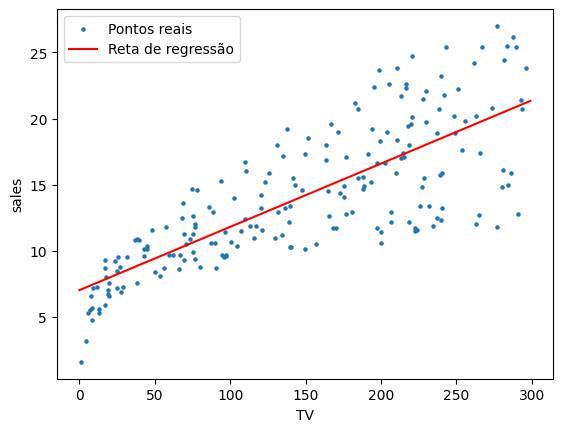

In [176]:
# plotando os resultados:

# plotando os pontos
pts = plt.scatter(X['TV'], y, s= 5, label = 'Pontos reais')

# plotando a reta obtida pela média dos 30 valores theta 0 e 1
med_t0 = df['Intercept'].mean()
med_t1 = df['Coeficiente'].mean()
reg_x = range(300)
reg_y = med_t0 + med_t1*reg_x
reg = plt.plot(reg_x, reg_y, color = 'red', label = 'Reta de regressão')

# finalziando o plot
plt.xlabel('TV') #x label
plt.ylabel('sales') #y label
plt.legend()
plt.show()

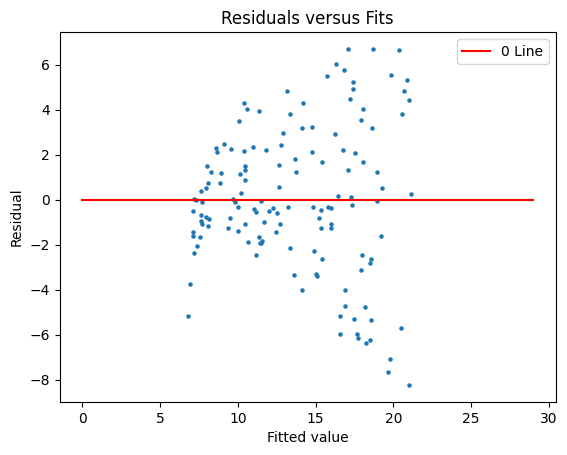

In [177]:
# Determinando se um valor de R-Squared é bom...
# isso pode ser feito ao plotar o gráfico Residuals x Fit
# verificando se os resíduos são consistestes com o random error, ou seja, o modelo não está enviesado

# plotando os pontos
pts = plt.scatter(fitted_val, residuals, s= 5)
# plotando a linha
line = plt.plot(range (30), np.zeros(30), color = 'red', label = '0 Line')
# finalziando o plot
plt.title('Residuals versus Fits')
plt.xlabel('Fitted value') #x label
plt.ylabel('Residual') #y label
plt.legend()
plt.show()

In [178]:
# Note que os resíduos não estão tão distribuídos de acordo com o random error,
# portanto, isso indica certa necessidade de alterção no modelo.
df['R-squared'].mean()
# isso pode significar que nossa métrica obtida com R-squared seja um valor pior do que o percebido

0.6173482308455135

In [179]:
# exportando o dataframe obtido
df.to_csv('/content/sample_data/Advertising_results.csv', index=False)

In [180]:
#----------------------------------------------------------------------------------------------
# Podemos tentar normalizar a feature de entrada para tentar obter algum ganho com as métricas
#----------------------------------------------------------------------------------------------

# resetando a lista para construir o dataframe
lInfo = []

In [181]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X, y)
# tentando algum resultado diferente com a normalização dos dados
for i in range(1,N_sub+1):
  #print("Run", i)
  X_train, X_test, y_train, y_test = generateTrainTest(X_norm, y)
  # constroi o modelo
  model = LinearRegression()

  # treina o modelo
  model.fit(X_train, y_train)

  # faz predição sobre o conjunto de TREINO, para observar os erros
  y_pred = model.predict(X_train)

  # informações para inserir no df
  coef = model.coef_[0]
  intercept = model.intercept_
  eq = "y = " + str(coef) + " * X + " + str(intercept)
  RSSv = RSS(y_train, y_pred)
  RSEv = RSE(y_train, y_pred)
  SETheta0v = SETheta0(X_train, RSEv)
  SETheta1v = SETheta1(X_train, RSEv)
  RSquared = model.score(X_train, y_train)
  RSqAdj = R_sq_Adjusted(len(X_train), 1, RSquared)
  # t-stats para o teste de hipótese, onde
  # a hipótese nula = Não existe relação entre X e y (Theta1 = 0)
  # "Sample mean (theta 1) minus population mean you are comparing your sample to (0),
  # divided by the standard error (SETheta1v).
  t_stats = (coef - 0)/SETheta1v
  P_value = f_regression(X_train, y_train)[1][0]

  # informações adicionais
  residuals = y_train - y_pred
  fitted_val = y_pred

  lInfo.append(pd.Series([coef, intercept, eq, RSSv, RSEv, SETheta0v, SETheta1v, RSquared, RSqAdj, t_stats, P_value], index=columns))

In [182]:
# criando o df
df = pd.DataFrame(lInfo)
df

,Coeficiente,Intercept,Equação,RSS (Residual Sum of Squares),RSE (Residual Standard Error),SE (Standard Error) para Theta 0,SE (Standard Error) para Theta 1,R-squared,R-sq-Adjusted,t-statistics,P-value
0,13.681540,7.206000,y = 13.681540037768318 * X + 7.2059996695193576,1517.167187,3.315715,[0.5598094592299195],[0.9698996423177578],0.590484,0.587517,[14.106139894096364],1.549434e-28
1,14.295855,7.155814,y = 14.29585489285225 * X + 7.1558142562188065,1365.714817,3.145868,[0.5313226716521532],[0.9345289430393389],0.629042,0.626354,[15.297391267902622],1.634696e-31
2,13.663506,7.250598,y = 13.663506300774898 * X + 7.250597692631771,1490.297966,3.286223,[0.5385646625099885],[0.9464324457054522],0.601643,0.598756,[14.436853219450215],2.282078e-29
3,14.663790,6.882337,y = 14.663789903017946 * X + 6.882336660153935,1442.251479,3.232816,[0.5419762366501711],[0.9572991114256032],0.629667,0.626983,[15.317876855835301],1.454618e-31
4,14.319027,6.919148,y = 14.319027189484979 * X + 6.919147914178675,1281.663195,3.047526,[0.5057188711804168],[0.8964697077723609],0.648968,0.646424,[15.972683812224235],3.567442e-33
5,14.336088,6.992957,y = 14.336088478403855 * X + 6.992956867026156,1505.351516,3.302778,[0.5428720614151147],[0.9380828916803431],0.628582,0.625891,[15.28232590696149],1.781252e-31
6,14.001765,7.083902,y = 14.001764806702605 * X + 7.083901879564387,1422.133686,3.210189,[0.5409221744518491],[0.9534016551949261],0.609819,0.606992,[14.686113381919709],5.420252e-30
7,13.687327,7.187368,y = 13.687327063852171 * X + 7.18736782577702,1609.547294,3.415170,[0.6007163832810841],[1.0109732052147893],0.570492,0.567380,[13.538763434332752],4.224508e-27
8,14.856222,6.714187,y = 14.856221755367724 * X + 6.7141872779857925,1412.883229,3.199732,[0.5296662157125989],[0.9232174960979118],0.652345,0.649826,[16.09178965753932],1.826200e-33
9,13.432561,7.216481,y = 13.432560532049289 * X + 7.216480925574689,1506.189205,3.303697,[0.5570751148507505],[0.9713179769625543],0.580862,0.577825,[13.8292102592961],7.755546e-28


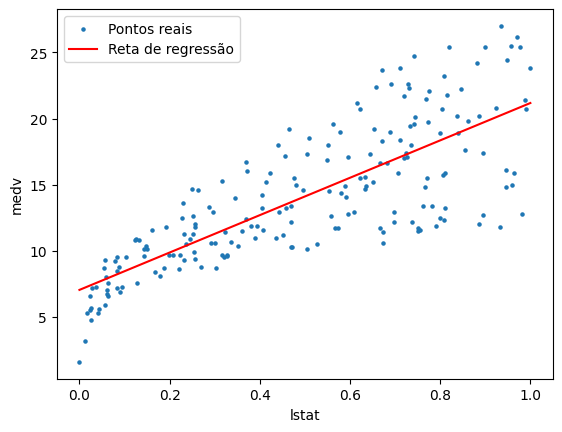

In [183]:
# plotando os resultados:

# plotando os pontos
pts = plt.scatter(X_norm, y, s= 5, label = 'Pontos reais')

# plotando a reta obtida pela média dos 30 valores theta 0 e 1
med_t0 = df['Intercept'].mean()
med_t1 = df['Coeficiente'].mean()
reg_x = np.arange(0.0,1.1,0.1)
reg_y = med_t0 + med_t1*reg_x
reg = plt.plot(reg_x, reg_y, color = 'red', label = 'Reta de regressão')

# finalziando o plot
plt.xlabel('lstat') #x label
plt.ylabel('medv') #y label
plt.legend()
plt.show()

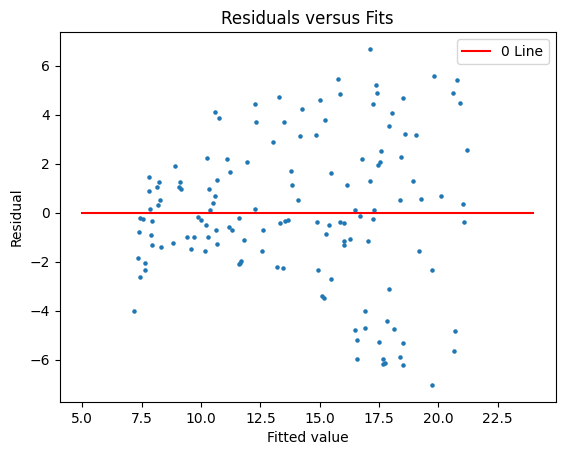

In [184]:
# Determinando se um valor de R-Squared é bom...
# isso pode ser feito ao plotar o gráfico Residuals x Fit
# verificando se os resíduos são consistestes com o random error, ou seja, o modelo não está enviesado

# plotando os pontos
pts = plt.scatter(fitted_val, residuals, s= 5)
# plotando a linha
line = plt.plot(range (5, 25), np.zeros(20), color = 'red', label = '0 Line')
# finalziando o plot
plt.title('Residuals versus Fits')
plt.xlabel('Fitted value') #x label
plt.ylabel('Residual') #y label
plt.legend()
plt.show()

In [185]:
# Note que os resíduos não estão tão distribuídos de acordo com o random error,
# portanto, isso indica certa necessidade de alterção no modelo.
df['R-squared'].mean()
# isso pode significar que nossa métrica obtida com R-squared seja um valor pior do que o percebido


0.6186136490710751

In [186]:
# finalizando a análise após a normalização da feature, não conseguimos muitos ganhos para o modelo.